# Notebook 7 — Numerical Methods & Scientific Computing

Covers floating-point basics, root finding, numerical differentiation & integration, solving linear systems, power iteration, and practical exercises for ML/AI use-cases.

Run cells sequentially. Exercises are marked with `# TODO`.

## 1. Floating-point arithmetic & machine epsilon

**Key ideas:**
- Numbers in Python are IEEE-754 doubles (approximately 53 bits of mantissa).
- Machine epsilon (`eps`) is the smallest number such that `1 + eps != 1`.
- Round-off error, cancellation, overflow/underflow are practical concerns.

Let's compute machine epsilon and demonstrate catastrophic cancellation.

In [1]:
import numpy as np

# Machine epsilon (numpy provides it)
eps = np.finfo(float).eps
print('numpy machine epsilon:', eps)

# Demonstrate cancellation: (1e16+1) - 1e16
a = 1e16
print('(a+1)-a =', (a + 1) - a)

# Compare with a smaller magnitude
b = 1e4
print('(b+1)-b =', (b + 1) - b)

# Representable spacing near 1.0
print('Spacing near 1.0:', np.nextafter(1.0, 2.0) - 1.0)

numpy machine epsilon: 2.220446049250313e-16
(a+1)-a = 0.0
(b+1)-b = 1.0
Spacing near 1.0: 2.220446049250313e-16


### Exercise 1
- Try `np.finfo(np.float32).eps` and compare to float64 eps.
- Experiment with `(a + delta) - a` for different `a` and `delta` to see when addition loses precision.

## 2. Root finding: Bisection and Newton-Raphson

We will implement:
- Bisection (guaranteed convergence for continuous functions with sign change)
- Newton-Raphson (fast quadratic convergence near root but needs derivative and good init)

Problem: find root of f(x) = x^3 - 2x - 5 (real root near x≈2.094).

In [2]:
def f(x):
    return x**3 - 2*x - 5

def f_prime(x):
    return 3*x**2 - 2

def bisection(func, a, b, tol=1e-8, max_iter=100):
    fa, fb = func(a), func(b)
    if fa * fb > 0:
        raise ValueError('Function has same sign at interval endpoints')
    for i in range(max_iter):
        c = 0.5*(a + b)
        fc = func(c)
        if abs(fc) < tol or (b - a)/2 < tol:
            return c
        if fa * fc <= 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
    return 0.5*(a + b)

def newton_raphson(func, func_prime, x0, tol=1e-10, max_iter=100):
    x = x0
    for i in range(max_iter):
        fx = func(x)
        fpx = func_prime(x)
        if fpx == 0:
            raise ZeroDivisionError('Zero derivative encountered')
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    return x

# Run methods
root_bis = bisection(f, 1, 3)
root_newt = newton_raphson(f, f_prime, 2.0)
print('Bisection root:', root_bis)
print('Newton root   :', root_newt)

Bisection root: 2.094551481306553
Newton root   : 2.0945514815423265


### Exercise 2
- Try Newton-Raphson with a bad initial guess (x0 = -2) and observe behavior.
- Implement a safe Newton method with backtracking or max step constraint.

## 3. Numerical Differentiation

Finite differences:
- Forward: f'(x) ≈ (f(x+h) - f(x)) / h
- Backward: f'(x) ≈ (f(x) - f(x-h)) / h
- Central (more accurate): f'(x) ≈ (f(x+h) - f(x-h)) / (2h)

Let's compare central vs forward differences for sin(x) at x=1.0.

In [3]:
import math

def numeric_derivative(func, x, h=1e-6, method='central'):
    if method == 'forward':
        return (func(x + h) - func(x)) / h
    elif method == 'backward':
        return (func(x) - func(x - h)) / h
    else:
        return (func(x + h) - func(x - h)) / (2*h)

x0 = 1.0
h_vals = [1e-1, 1e-3, 1e-6, 1e-8]
true = math.cos(x0)
print('true derivative cos(1) =', true)
for h in h_vals:
    fd = numeric_derivative(math.sin, x0, h, 'forward')
    cd = numeric_derivative(math.sin, x0, h, 'central')
    print(f'h={h:.0e}: forward_err={abs(fd-true):.3e}, central_err={abs(cd-true):.3e}')

true derivative cos(1) = 0.5403023058681398
h=1e-01: forward_err=4.294e-02, central_err=9.001e-04
h=1e-03: forward_err=4.208e-04, central_err=9.005e-08
h=1e-06: forward_err=4.207e-07, central_err=2.772e-11
h=1e-08: forward_err=1.407e-08, central_err=2.970e-09


### Exercise 3
- Plot error vs h (log-log) for forward and central difference and observe the slopes.
- Explain why central is more accurate (error ∝ h^2) while forward/backward ∝ h.

## 4. Numerical Integration

Implement trapezoidal rule and Simpson's rule. Compare to analytical integrals and Monte Carlo integration for higher dimensions.

Example: ∫₀¹ e^{x} dx = e - 1

In [4]:
def trapezoidal_rule(func, a, b, n=1000):
    x = np.linspace(a, b, n+1)
    y = func(x)
    h = (b - a) / n
    return (h/2) * (y[0] + 2*y[1:-1].sum() + y[-1])

def simpsons_rule(func, a, b, n=1000):
    if n % 2 == 1:
        n += 1  # Simpson requires even n
    x = np.linspace(a, b, n+1)
    y = func(x)
    h = (b - a) / n
    return (h/3) * (y[0] + 4*y[1:-1:2].sum() + 2*y[2:-1:2].sum() + y[-1])

import math
analytic = math.e - 1
trap = trapezoidal_rule(np.exp, 0, 1, n=100)
simp = simpsons_rule(np.exp, 0, 1, n=100)
print('analytic =', analytic)
print('trapezoidal (n=100) =', trap, 'error=', abs(trap-analytic))
print('simpson (n=100)     =', simp, 'error=', abs(simp-analytic))

analytic = 1.718281828459045
trapezoidal (n=100) = 1.7182961474504177 error= 1.431899137260828e-05
simpson (n=100)     = 1.7182818285545043 error= 9.545919610332021e-11


### Exercise 4
- Implement Monte Carlo integration to estimate ∫₀¹ e^{x} dx and compare variance with n.
- Try a 2D Monte Carlo estimate of the integral over [0,1]² of f(x,y)=exp(x+y).

## 5. Solving Linear Systems: Gaussian elimination & LU

We will use `numpy.linalg.solve` for accuracy, but also show basic LU via `scipy.linalg` (if available).
Solve A x = b with A a 3x3 matrix.

In [5]:
A = np.array([[3.0, 2.0, -1.0],[2.0, -2.0, 4.0],[-1.0, 0.5, -1.0]])
b = np.array([1.0, -2.0, 0.0])

x = np.linalg.solve(A, b)
print('Solution x =', x)

# Verify
print('A @ x =', A.dot(x))

try:
    from scipy.linalg import lu
    P, L, U = lu(A)
    print('\nLU decomposition available (scipy):')
    print('P:\n', P)
    print('L:\n', L)
    print('U:\n', U)
except Exception as e:
    print('\nscipy.linalg.lu not available or import failed:', e)

Solution x = [ 1. -2. -2.]
A @ x = [ 1.00000000e+00 -2.00000000e+00 -2.22044605e-16]

LU decomposition available (scipy):
P:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L:
 [[ 1.          0.          0.        ]
 [ 0.66666667  1.          0.        ]
 [-0.33333333 -0.35        1.        ]]
U:
 [[ 3.          2.         -1.        ]
 [ 0.         -3.33333333  4.66666667]
 [ 0.          0.          0.3       ]]


### Exercise 5
- Create a near-singular matrix (e.g., rows nearly linearly dependent) and observe numeric instability when solving.
- Use `np.linalg.cond(A)` to inspect condition number and relate it to solution sensitivity.

## 6. Power Iteration for Dominant Eigenpair

Power iteration finds the largest eigenvalue and associated eigenvector of a matrix (useful for PageRank-ish tasks and sanity checks).

In [6]:
def power_iteration(A, num_simulations: int = 100, tol=1e-10):
    # Random initial vector
    b_k = np.random.rand(A.shape[1])
    b_k = b_k / np.linalg.norm(b_k)
    lambda_old = 0.0
    for _ in range(num_simulations):
        # Calculate the matrix-by-vector product
        b_k1 = A.dot(b_k)
        # Re-normalize the vector
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm
        lambda_new = b_k.T.dot(A.dot(b_k))
        if abs(lambda_new - lambda_old) < tol:
            break
        lambda_old = lambda_new
    return lambda_new, b_k

M = np.array([[4.0, 1.0, 0.0],[1.0, 3.0, 1.0],[0.0,1.0,2.0]])
eigval, eigvec = power_iteration(M)
print('Estimated dominant eigenvalue:', eigval)
print('Estimated eigenvector:', eigvec)

# Compare to numpy
w, v = np.linalg.eig(M)
print('\nNumpy eigenvalues:', w)
idx = np.argmax(w)
print('Numpy dominant eigenvalue:', w[idx])

Estimated dominant eigenvalue: 4.73205080753773
Estimated eigenvector: [0.78867269 0.57735272 0.21132731]

Numpy eigenvalues: [4.73205081 3.         1.26794919]
Numpy dominant eigenvalue: 4.732050807568877


### Exercise 6
- Try power iteration on a large random symmetric matrix (e.g., 200x200) and compare time and accuracy with `np.linalg.eig`.
- Discuss when power iteration is preferable (large sparse matrices).

## 7. Numerical stability in optimization

- Discuss how poorly scaled features affect gradient descent.
- Practice: scale features and show faster convergence (or smaller condition number).

Final losses (unscaled): 6.84495948305069
Final losses (scaled)  : 0.009924386487246506


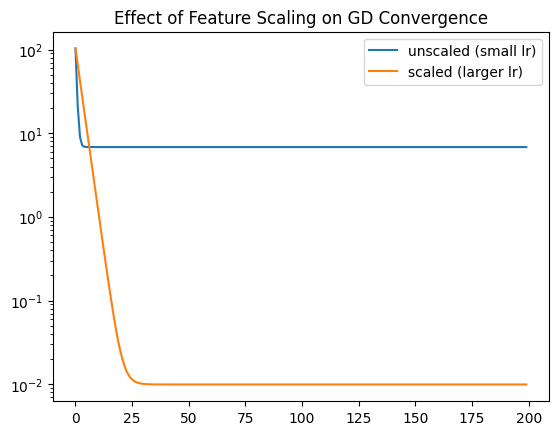

In [7]:
# Quick demo: effect of scaling on gradient descent for linear regression
np.random.seed(0)
X = np.random.rand(100, 1) * 1000  # poorly scaled feature
y = 5 + 0.01 * X[:,0] + np.random.randn(100) * 0.1

X_scaled = (X - X.mean()) / X.std()

def gd_linear(X, y, lr=0.1, epochs=100):
    m = 0.0
    b = 0.0
    n = len(y)
    losses = []
    for _ in range(epochs):
        y_pred = m * X.flatten() + b
        dm = (2/n) * np.sum((y_pred - y) * X.flatten())
        db = (2/n) * np.sum(y_pred - y)
        m -= lr * dm
        b -= lr * db
        losses.append(np.mean((y_pred - y)**2))
    return m, b, losses

m1, b1, losses1 = gd_linear(X, y, lr=0.000001, epochs=200)
m2, b2, losses2 = gd_linear(X_scaled, y, lr=0.1, epochs=200)

print('Final losses (unscaled):', losses1[-1])
print('Final losses (scaled)  :', losses2[-1])

import matplotlib.pyplot as plt
plt.plot(losses1, label='unscaled (small lr)')
plt.plot(losses2, label='scaled (larger lr)')
plt.yscale('log')
plt.legend()
plt.title('Effect of Feature Scaling on GD Convergence')
plt.show()

### Final Exercises (Consolidation)
1. Implement bisection, newton with safeguards, and compare iterations required.
2. Plot numerical derivative error vs h and fit slope to confirm order.
3. Implement Monte Carlo integration for a 3D integral and estimate standard error.
4. Create a nearly singular matrix, compute condition number, and show sensitivity of solution to tiny perturbations in b.
5. Use power iteration on a sparse random matrix (use `scipy.sparse` if available) and compare time to `scipy.sparse.linalg.eigs`.

## Notes & References
- Numerical Recipes (classic reference)
- Trefethen & Bau, *Numerical Linear Algebra*
- Higham, *Accuracy and Stability of Numerical Algorithms*
- SciPy docs for `scipy.linalg` and `scipy.sparse.linalg`